In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
batch_size = 32
img_height = 128
img_width = 128

data_dir = '/content/drive/MyDrive/ML_lab8'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # subset for training
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # subset for testing
)


Found 105 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


In [ ]:
!pip install pillow_heif

In [ ]:
# Convert each HEIC image to JPG
from PIL import Image
import pillow_heif
import os

heic_dir = '/content/drive/MyDrive/ML_lab8/Yashaswini'

for filename in os.listdir(heic_dir):
    if filename.endswith(".heic"):
        heif_file = pillow_heif.read_heif(os.path.join(heic_dir, filename))
        image = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )
        # Save as JPG in the same directory
        jpg_path = os.path.join(heic_dir, filename.replace(".heic", ".jpg"))
        image.save(jpg_path, "JPEG")

        # Delete the original HEIC file
        os.remove(os.path.join(heic_dir, filename))

In [ ]:
model = models.Sequential([
    # First Convolutional Layer with 32 filters, kernel size of 3x3, and ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    # Output layer with 1 unit and sigmoid activation for binary classification
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', # Adjusts learning rates
              loss='binary_crossentropy', # Difference between predicted and actual labels
              metrics=['accuracy'])


In [ ]:
# To check if there are any corrupted files which can cause error, like un converted heic files
from PIL import Image
import os

data_dir ='/content/drive/MyDrive/ML_lab8'
folders = ['Yashaswini', 'Aashish']

for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Corrupted or unreadable image: {file_path}")


In [ ]:
# If val_loss doesnt change significantly for 10 consecutive epochs, The model trainig terminates
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stopping]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5257 - loss: 0.7757 - val_accuracy: 0.4800 - val_loss: 0.7179
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5022 - loss: 0.7097 - val_accuracy: 0.5200 - val_loss: 0.6893
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5440 - loss: 0.6915 - val_accuracy: 0.5200 - val_loss: 0.6901
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5234 - loss: 0.6906 - val_accuracy: 0.5200 - val_loss: 0.6906
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5730 - loss: 0.6905 - val_accuracy: 0.6400 - val_loss: 0.6896
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4207 - loss: 0.6965 - val_accuracy: 0.4800 - val_loss: 0.6925
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5977 - loss: 0.6863 - val_accuracy: 0.4800 - val_loss: 0.6905
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5983 - loss: 0.6860 - val_accuracy: 0.6000 - val_loss: 0.6804
Epoch 9/20
4/4 ━━━━

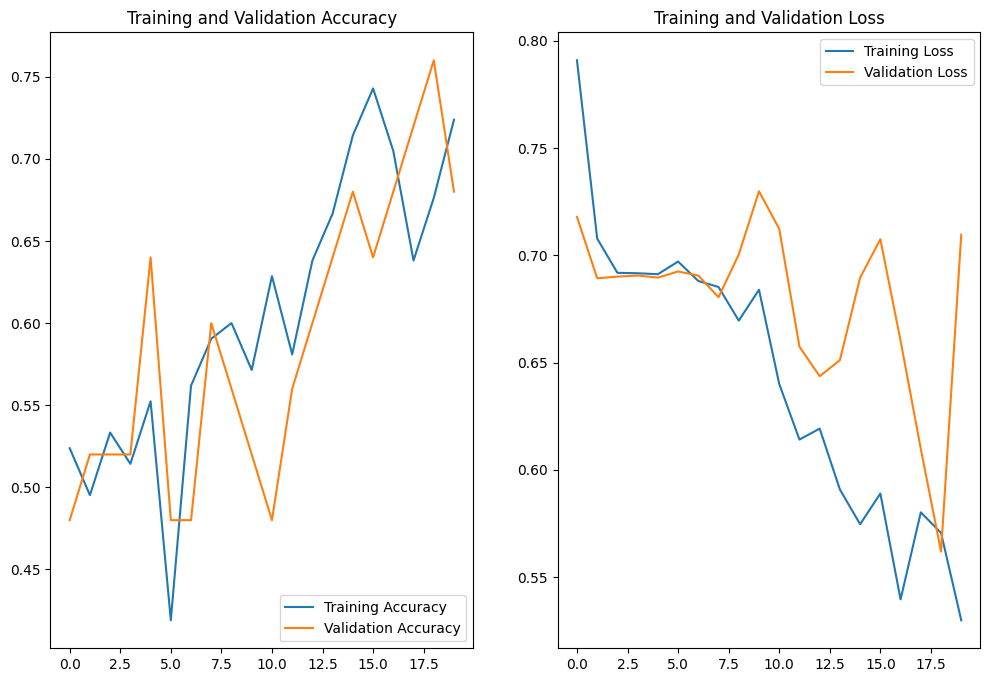

In [ ]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
